<a href="https://colab.research.google.com/github/ViniTelheiro/GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers



#Loading and pre-processing the dataset:

In [ ]:
(x_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()
x_train[0].min(), x_train[0].max()


11490434/11490434 [==============================] - 2s 0us/step


(0, 255)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')

#normalize between -1 and 1
x_train = (x_train - 127.5)/127.5

x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = x_train.shape[0]
batch_size = 256
buffer_size/batch_size

234.375

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
x_train

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Building DCGAN class:

In [ ]:
class DCGAN():
  def __init__(self) -> None:
    self.generator = self.__create_generator()
    self.discriminator = self.__create_discriminator()

    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

    self.generator_optimizier = tf.keras.optimizers.Adam(learning_rate=1e-5)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


  def __create_generator(self):
    network = tf.keras.Sequential()

    network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Reshape((7,7,256)))

    network.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), padding='same', use_bias=False, strides=(2,2)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    network.add(layers.Conv2DTranspose(filters=1, kernel_size=(5,5), use_bias=False, strides=(2,2), padding='same', activation='tanh'))
    
    return network


  def __create_discriminator(self):
    network = tf.keras.Sequential()
    
    network.add(layers.Conv2D(filters=64, strides=(2,2), kernel_size=(5,5), padding='same', input_shape=(28,28,1)))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(.3))

    network.add(layers.Conv2D(filters=128, strides=(2,2), kernel_size=(5,5), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(.3))

    network.add(layers.Flatten())

    network.add(layers.Dense(1, activation='sigmoid'))

    return network


  def __discriminator_loss(self, expected_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    
    return total_loss


  def __generator_loss(self,fake_output):
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)
  

  @tf.function
  def __train(self, images, batch_size:int):
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #um gradiente para o discriminador e outro para o gerador
      generated_image = self.generator(noise, training=True)
      
      expected_output = self.discriminator(images, training=True)
      fake_output = self.discriminator(generated_image, training = True)

      gen_loss = self.__generator_loss(fake_output)
      disc_loss = self.__discriminator_loss(expected_output=expected_output, fake_output=fake_output)

      gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizier.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))


  def train_gan(self, dataset, epochs:int, batch_size:int):
    for epoch in range(epochs):
      for batch_image in dataset:
        self.__train(images=batch_image, batch_size=batch_size)
      print(f'Epoch: {epoch+1}')
      self.generate_img()

    print('GAN trained with success!')


  def generate_img(self):
      test_images = tf.random.normal((16, 100))
      generated_images = self.generator(test_images, training=False)
      fig = plt.figure(figsize=(10,10))
      for i in range(generated_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
      plt.show()


In [ ]:
dcgan = DCGAN()

In [ ]:
dcgan.generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
dcgan.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

#Training the model and visualize results:

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch: 1


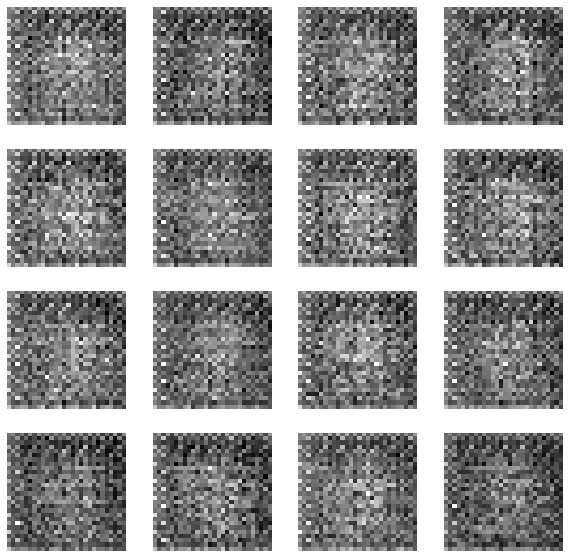

Epoch: 2


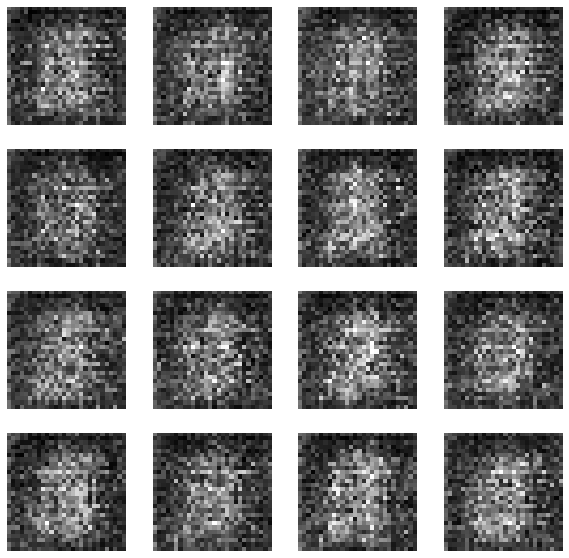

Epoch: 3


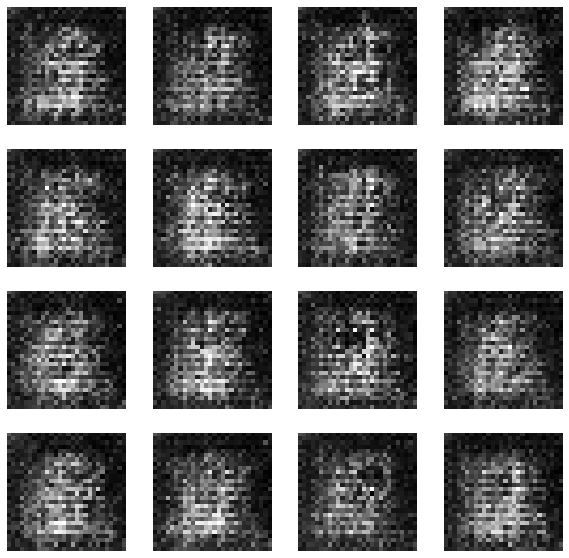

Epoch: 4


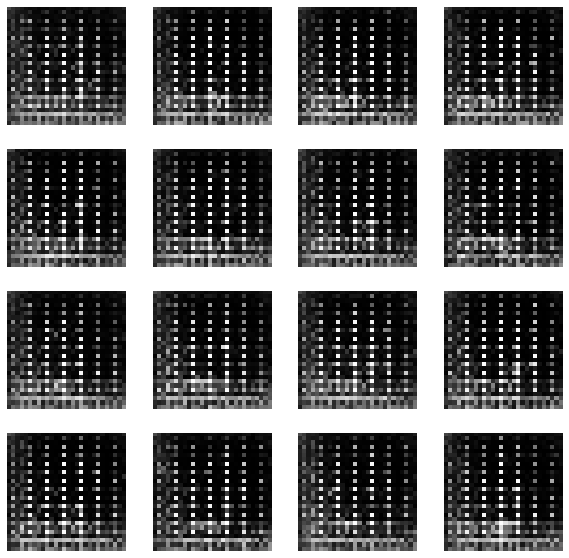

Epoch: 5


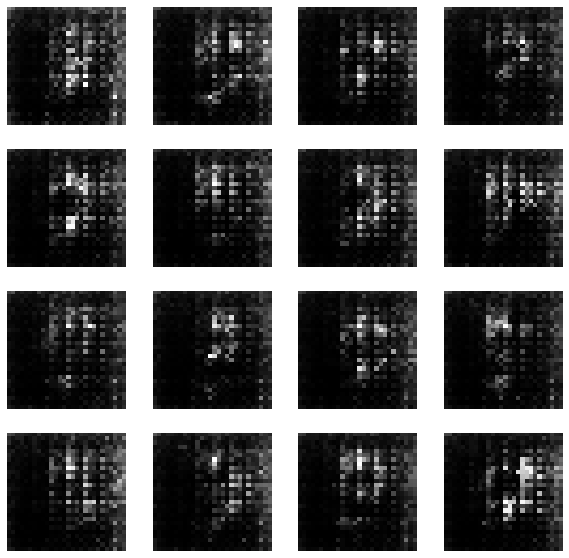

Epoch: 6


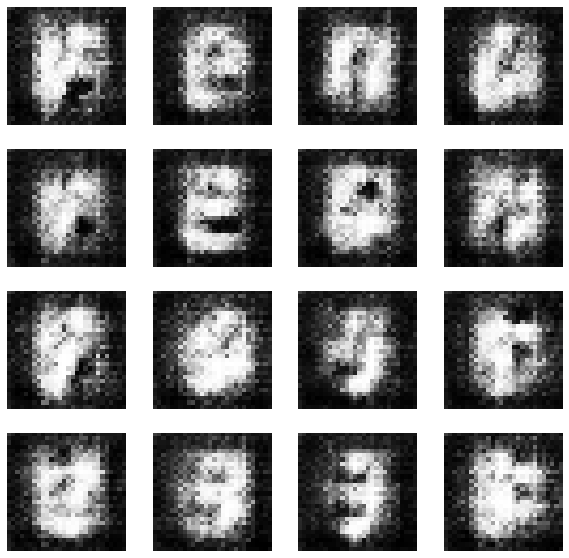

Epoch: 7


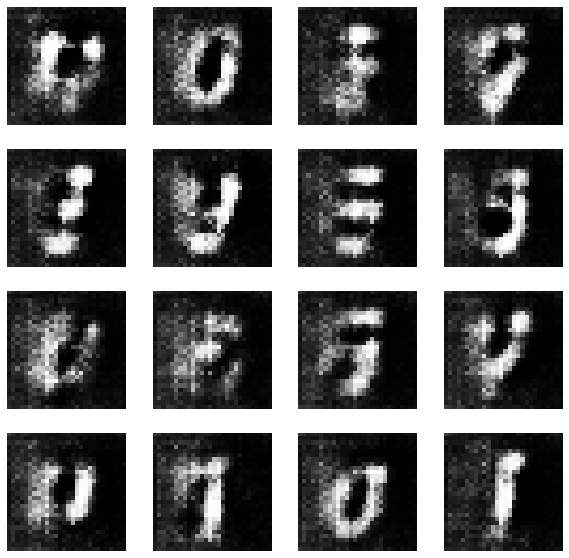

Epoch: 8


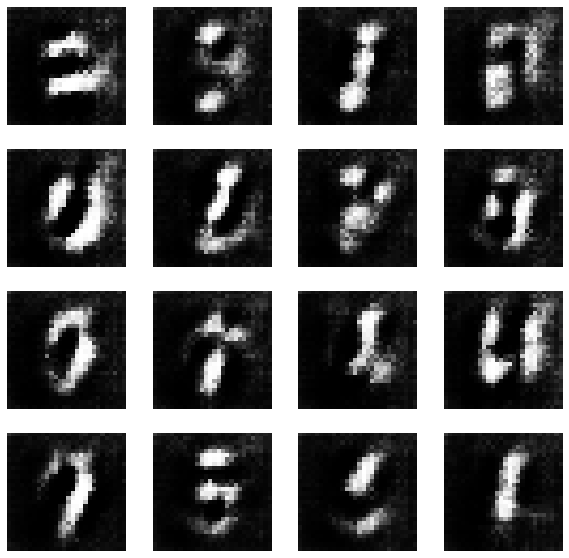

Epoch: 9


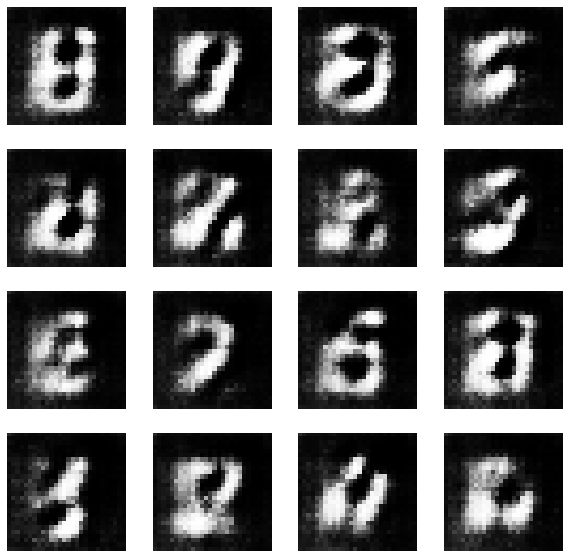

Epoch: 10


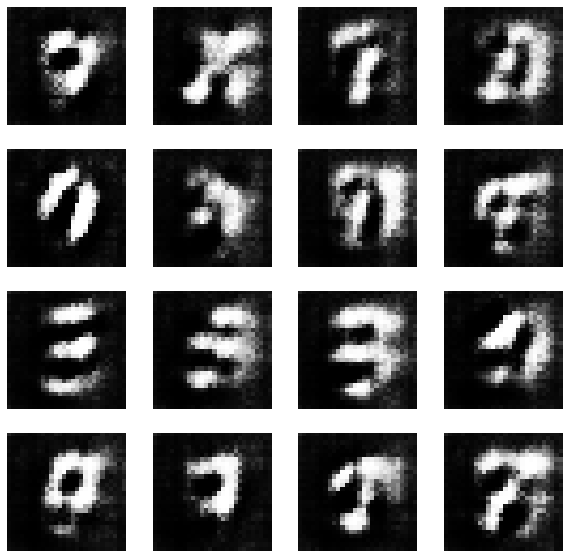

Epoch: 11


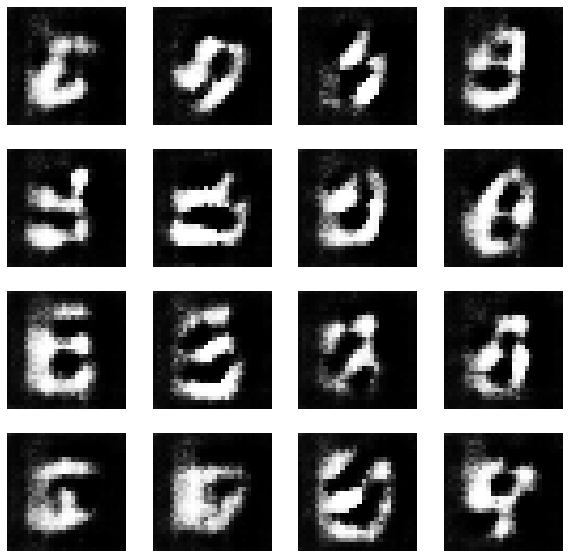

Epoch: 12


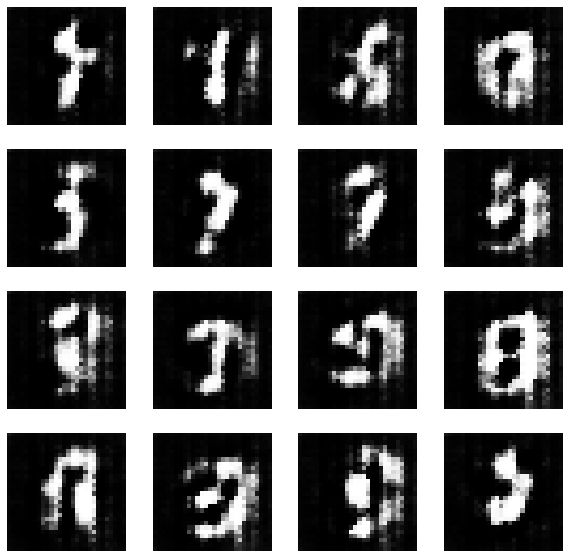

Epoch: 13


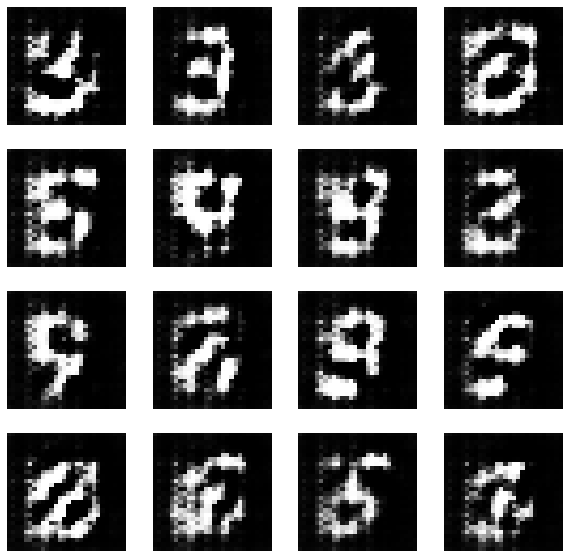

Epoch: 14


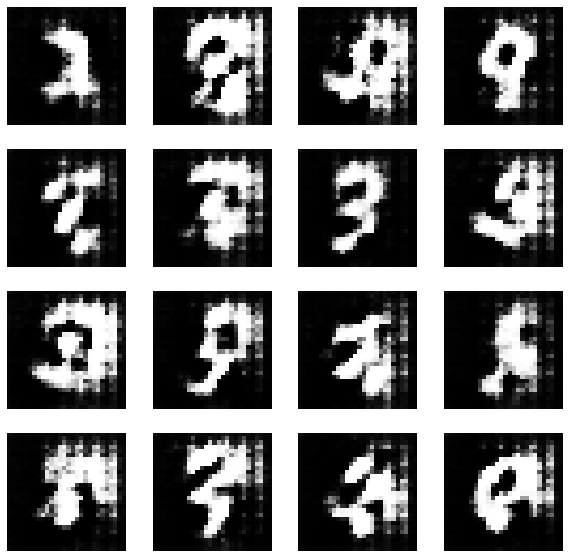

Epoch: 15


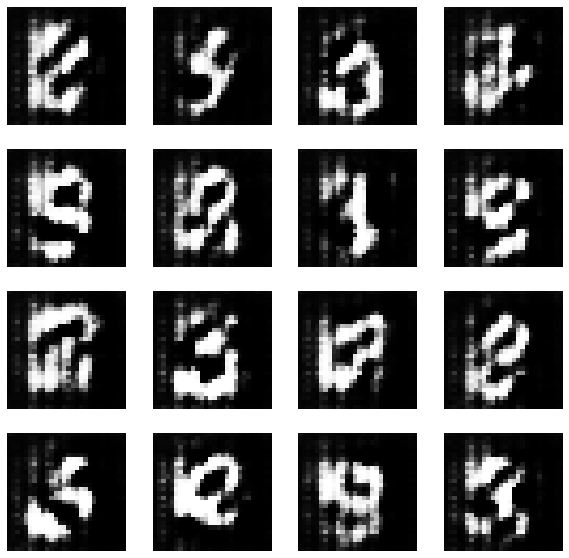

Epoch: 16


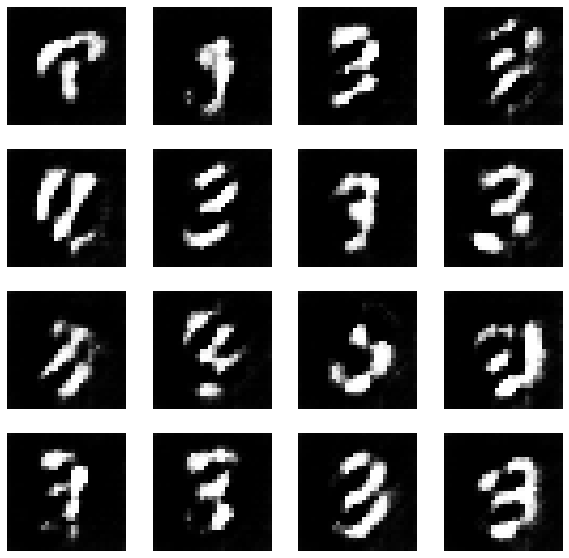

Epoch: 17


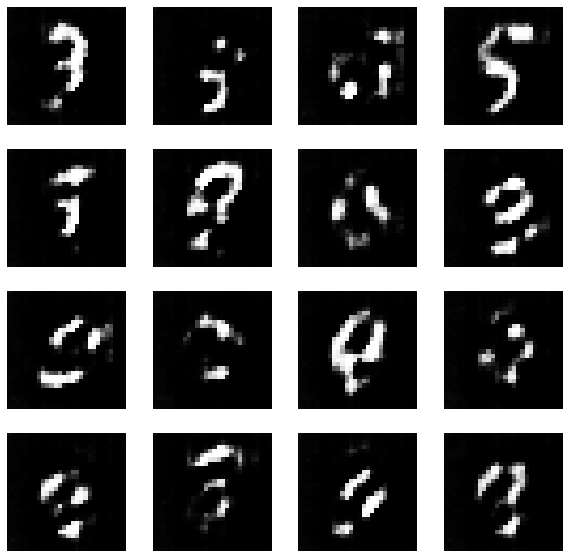

Epoch: 18


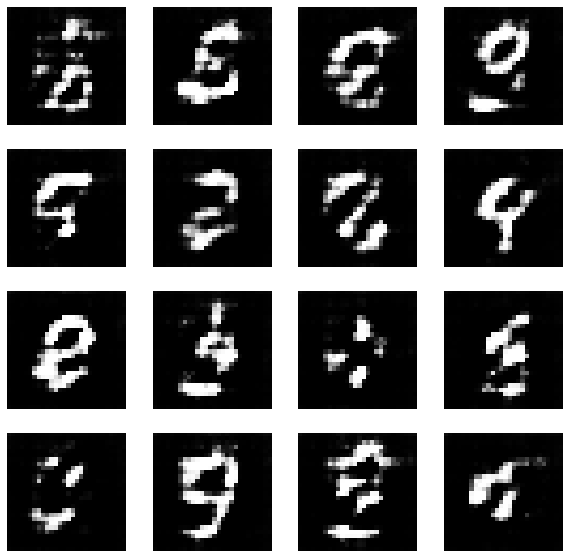

Epoch: 19


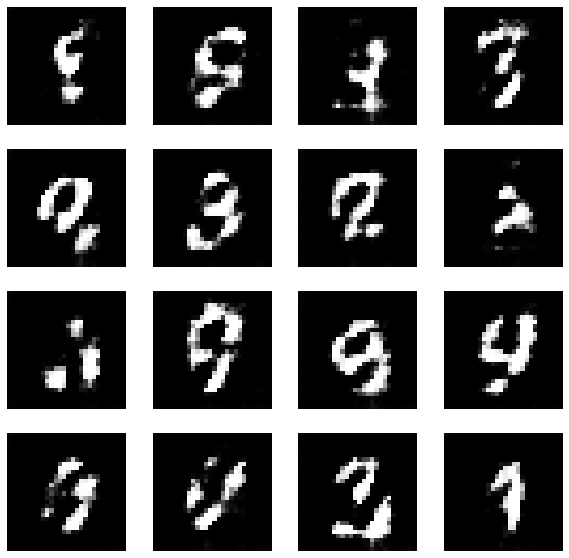

Epoch: 20


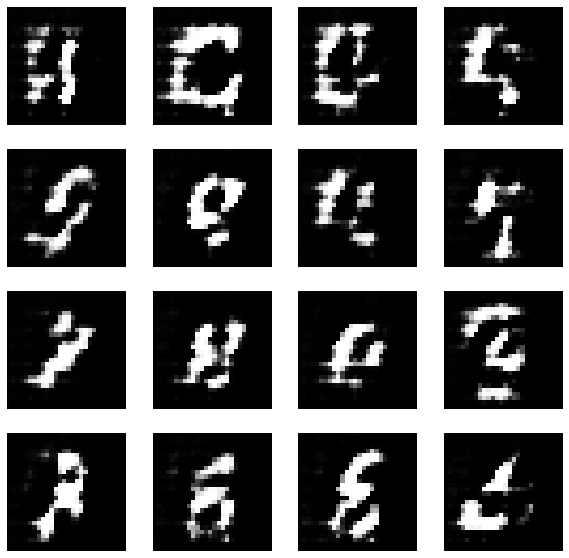

Epoch: 21


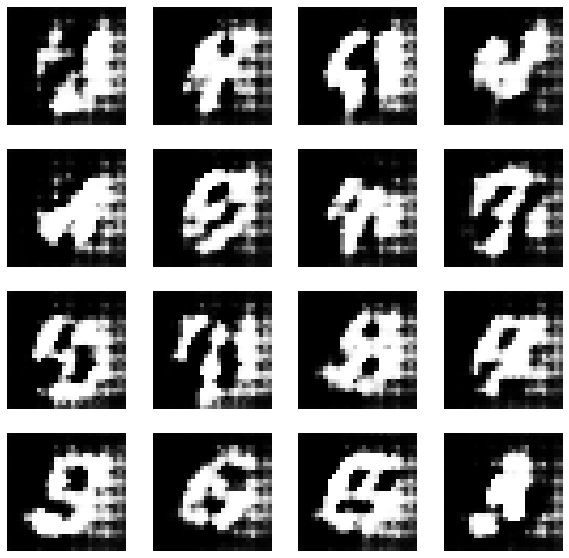

Epoch: 22


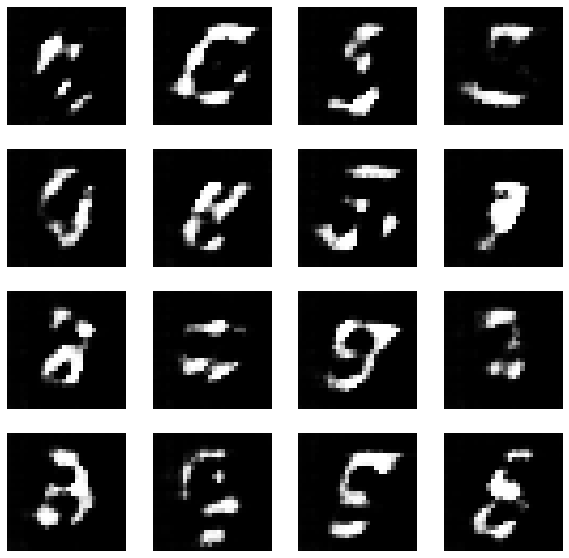

Epoch: 23


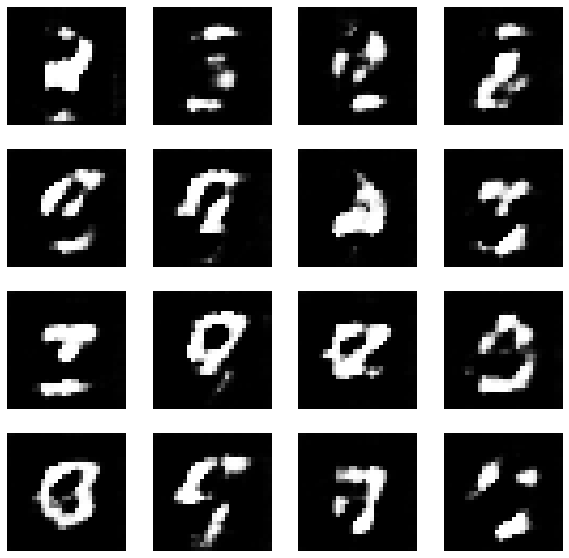

Epoch: 24


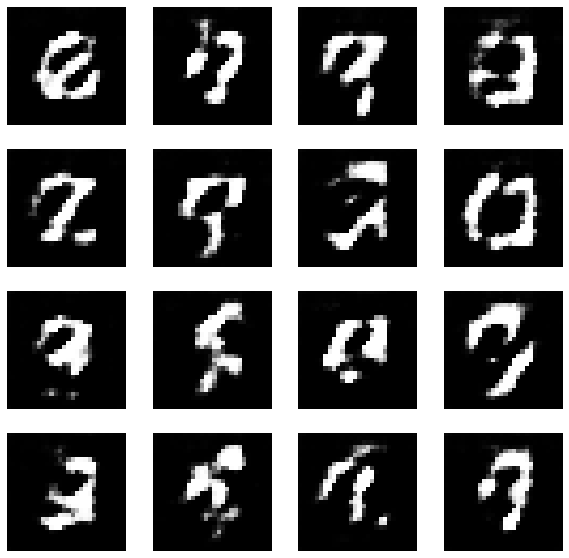

Epoch: 25


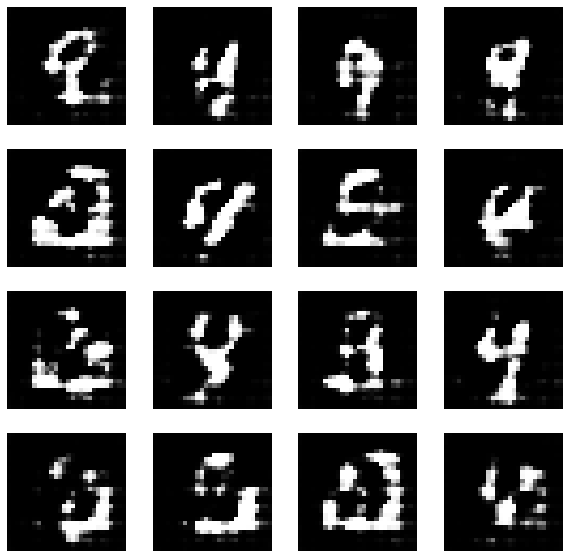

Epoch: 26


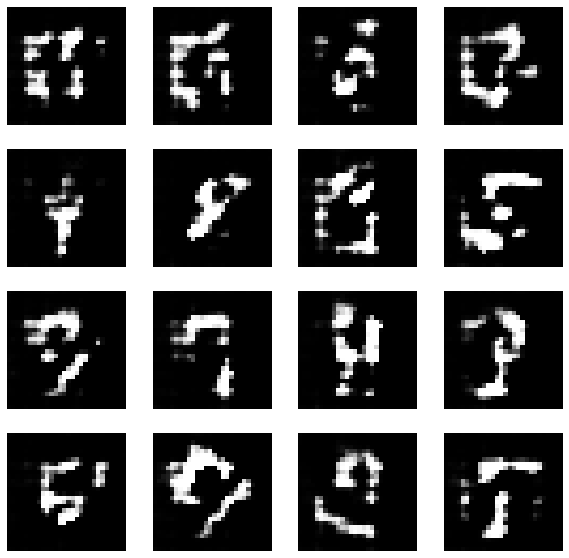

Epoch: 27


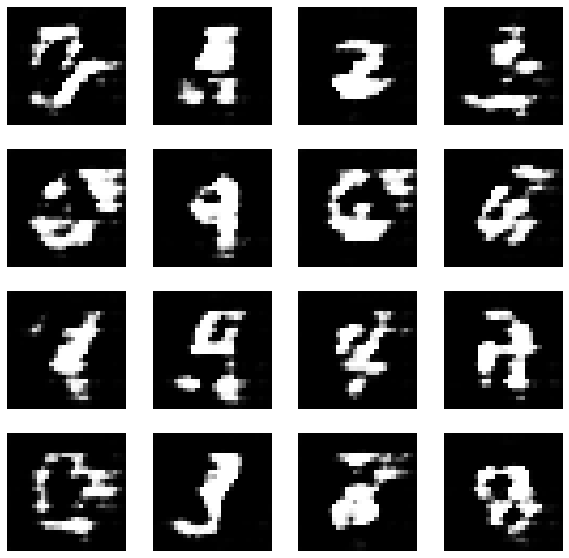

Epoch: 28


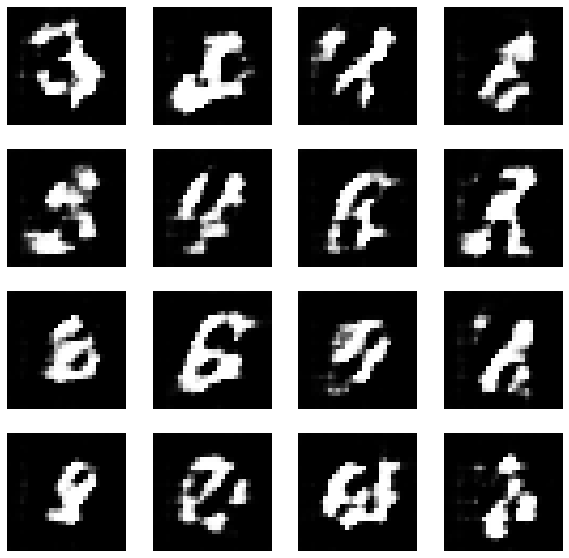

Epoch: 29


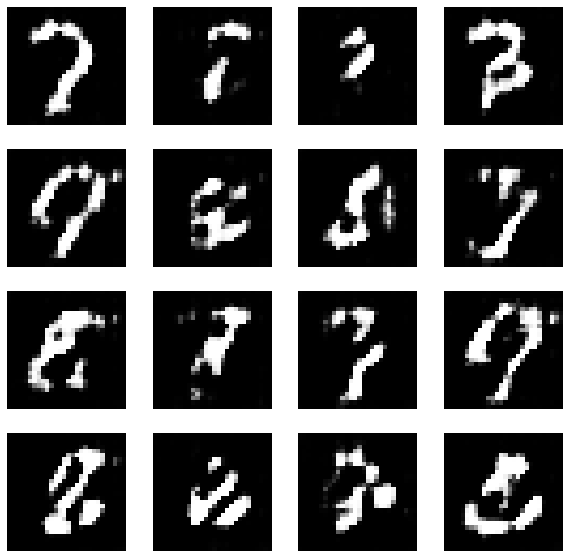

Epoch: 30


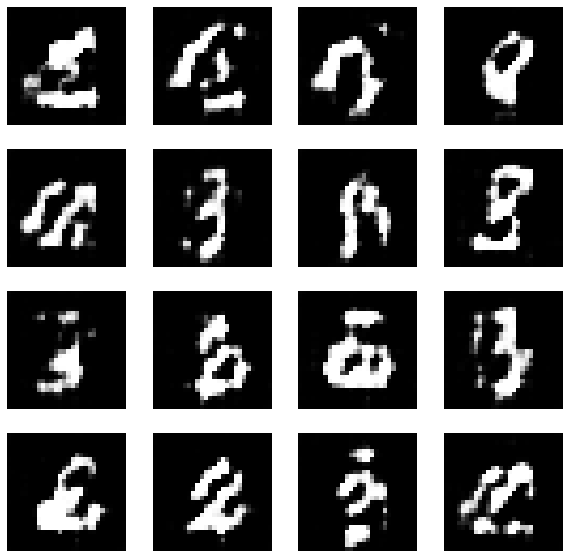

Epoch: 31


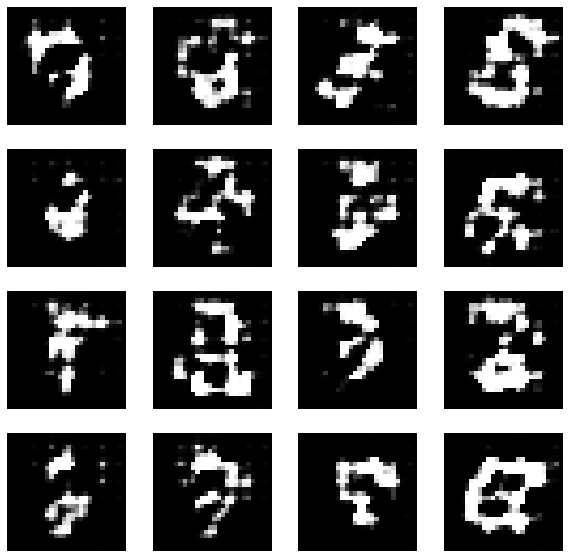

Epoch: 32


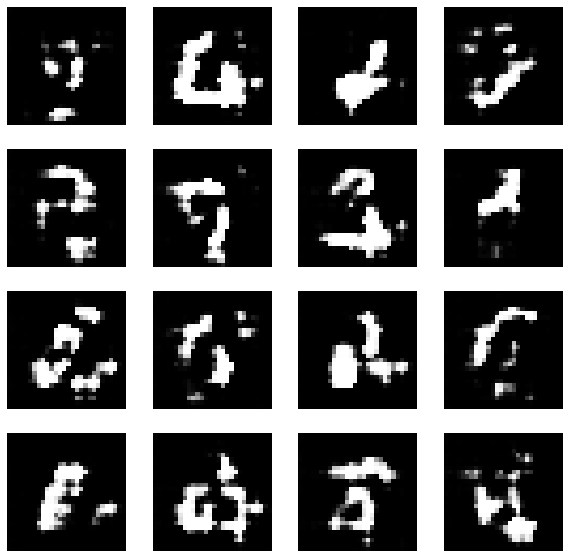

Epoch: 33


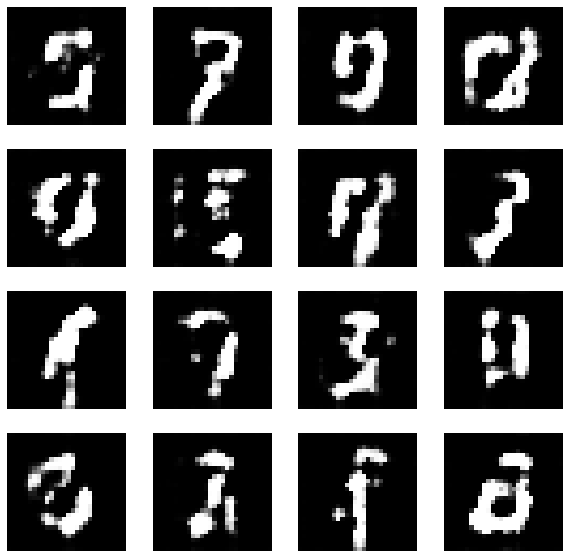

Epoch: 34


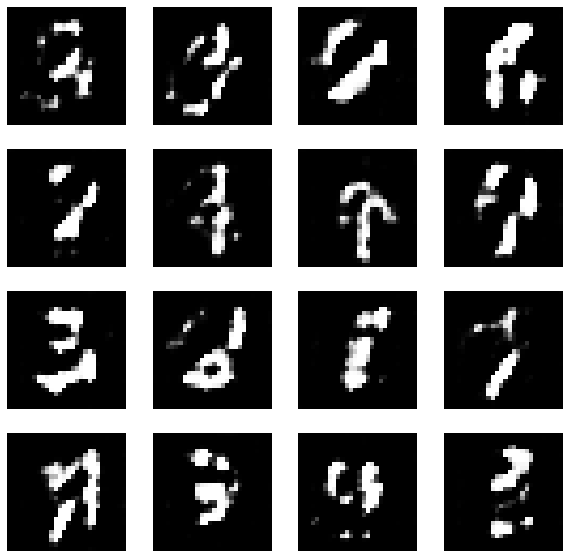

Epoch: 35


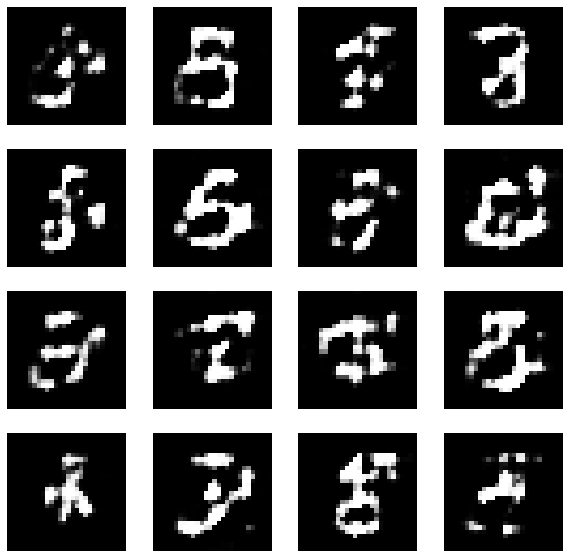

Epoch: 36


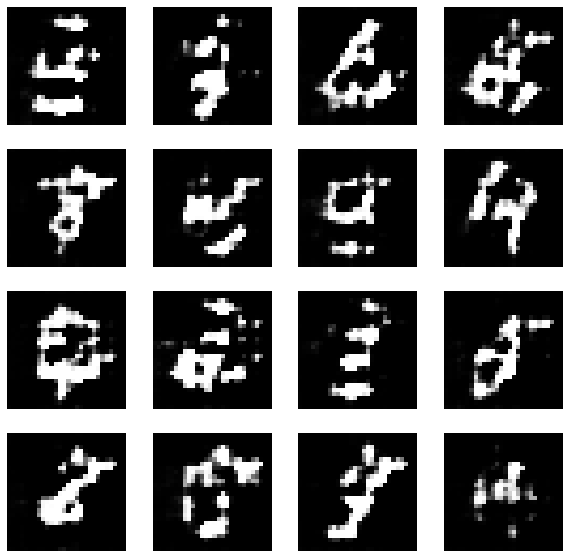

Epoch: 37


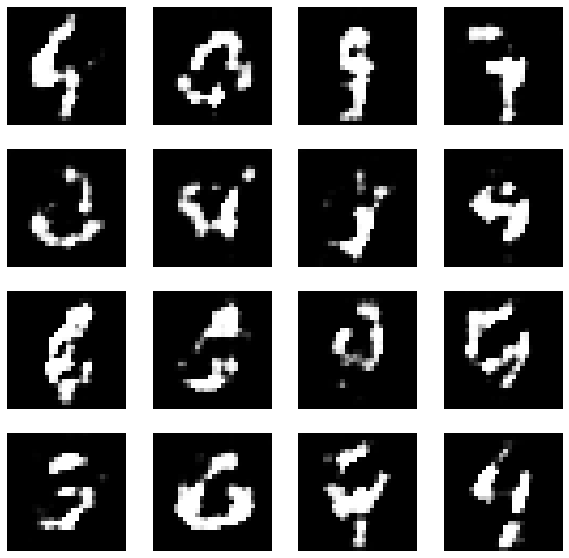

Epoch: 38


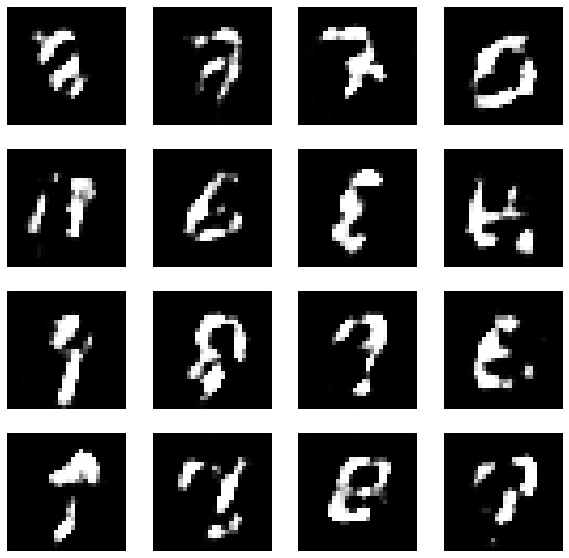

Epoch: 39


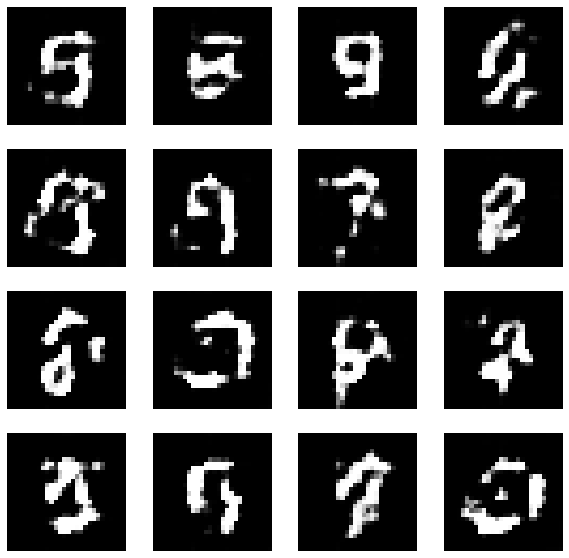

Epoch: 40


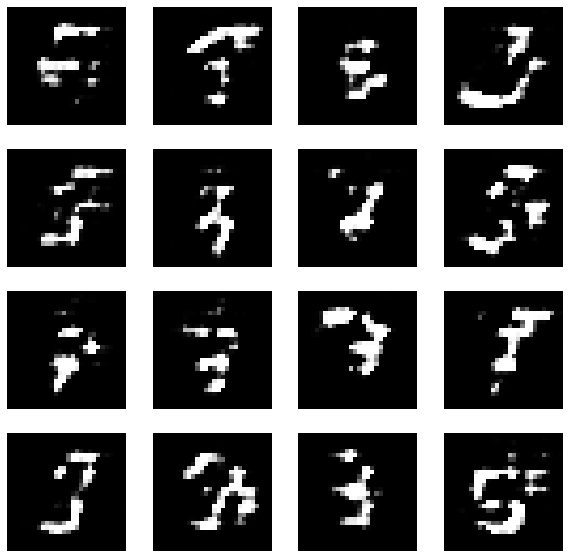

Epoch: 41


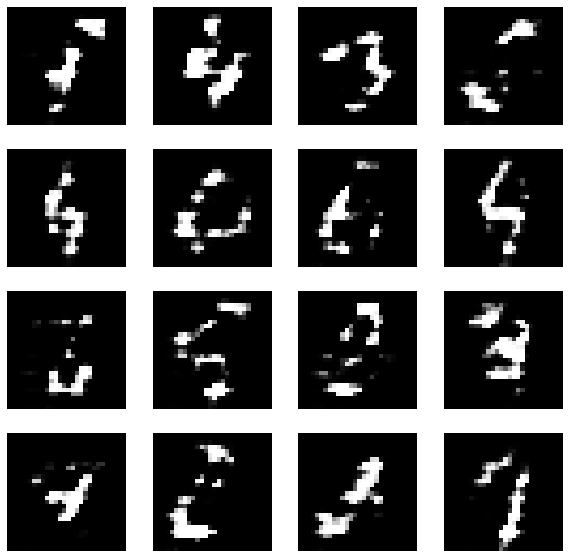

Epoch: 42


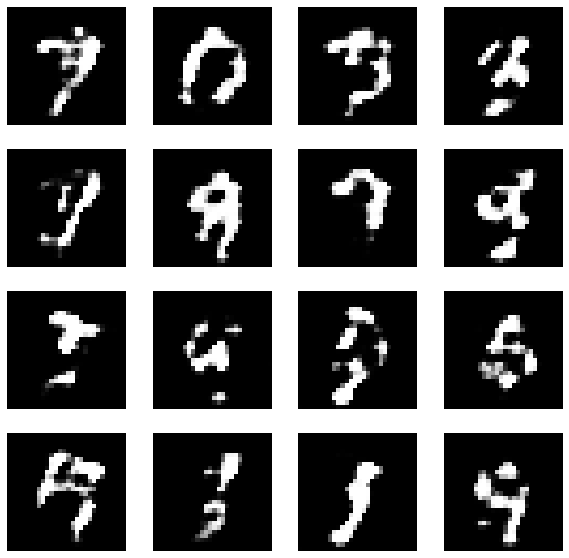

Epoch: 43


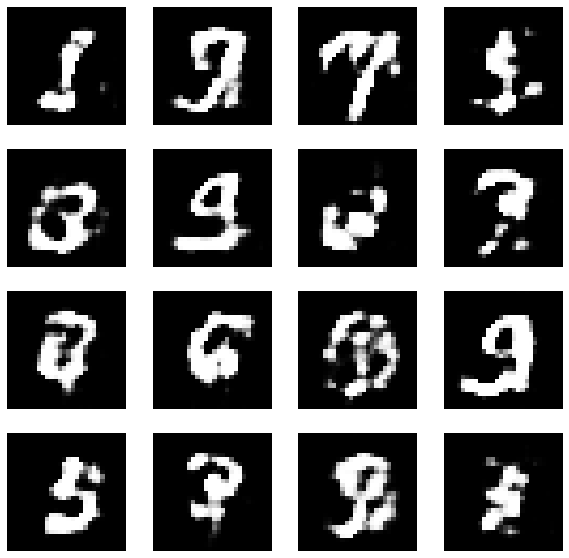

Epoch: 44


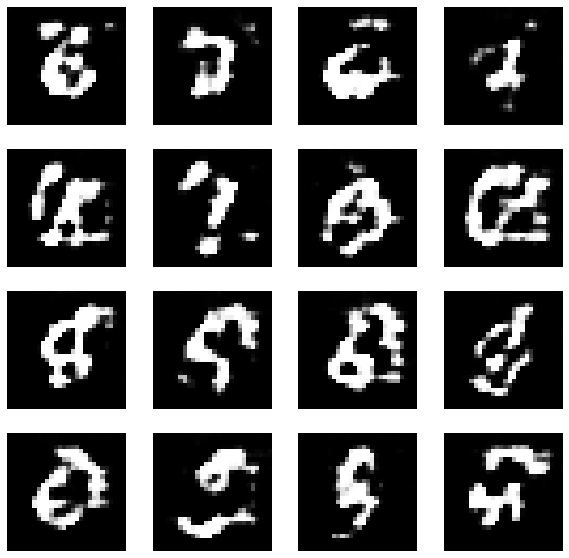

Epoch: 45


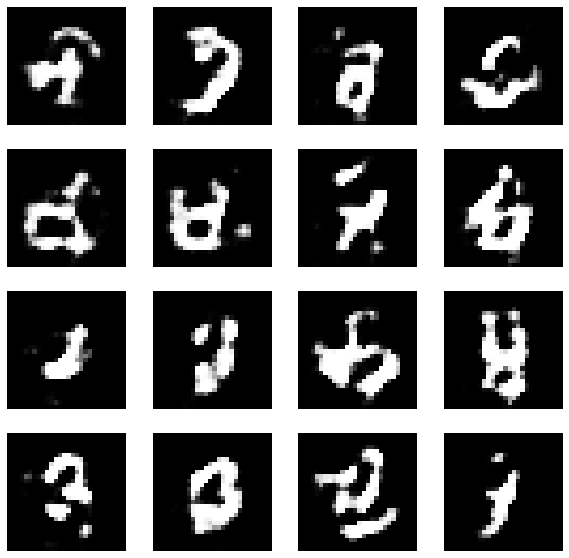

Epoch: 46


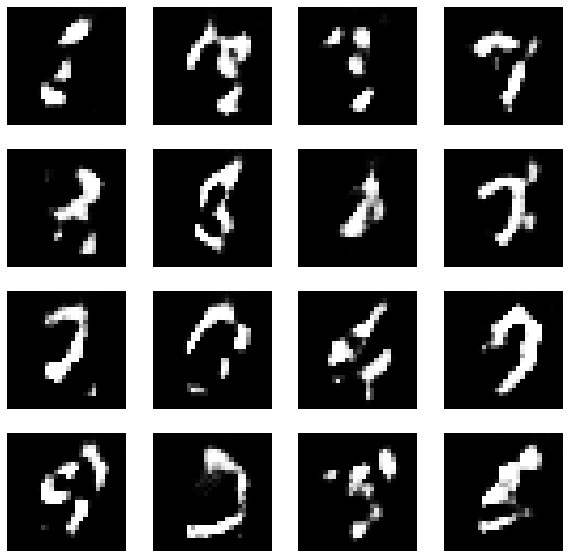

Epoch: 47


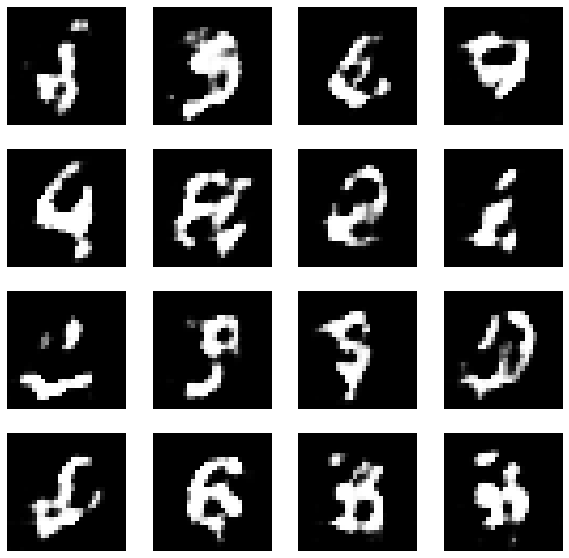

Epoch: 48


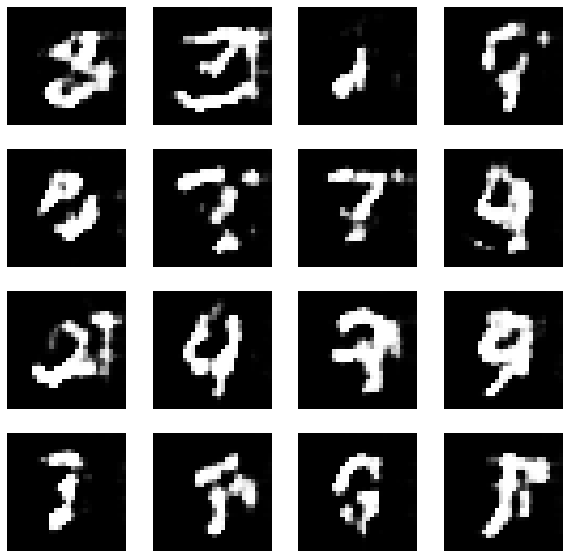

Epoch: 49


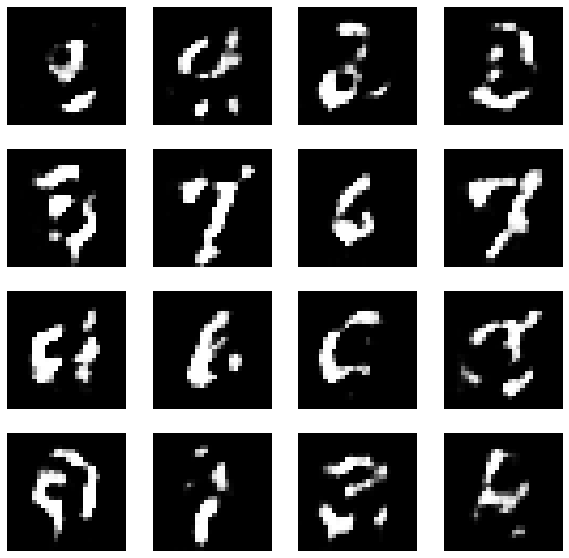

Epoch: 50


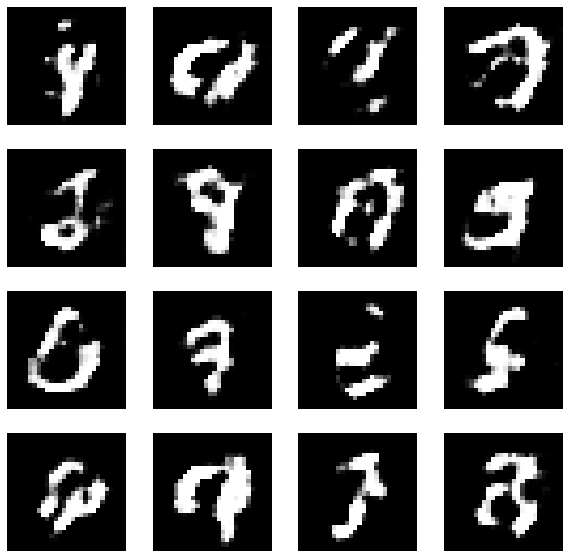

Epoch: 51


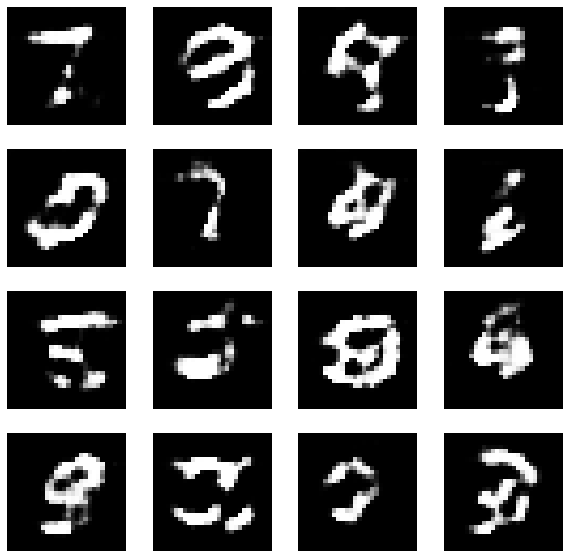

Epoch: 52


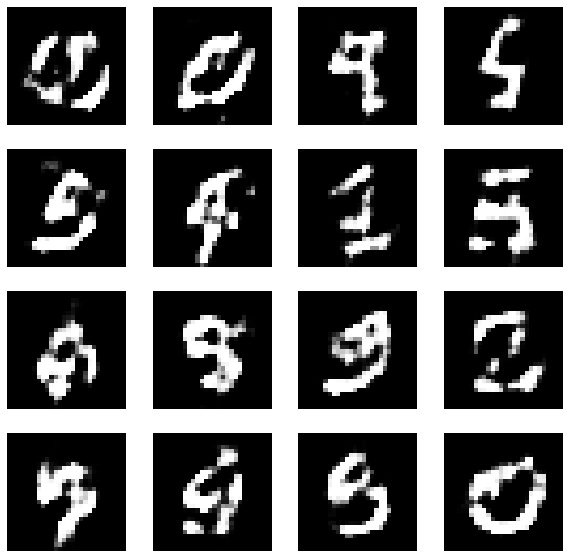

Epoch: 53


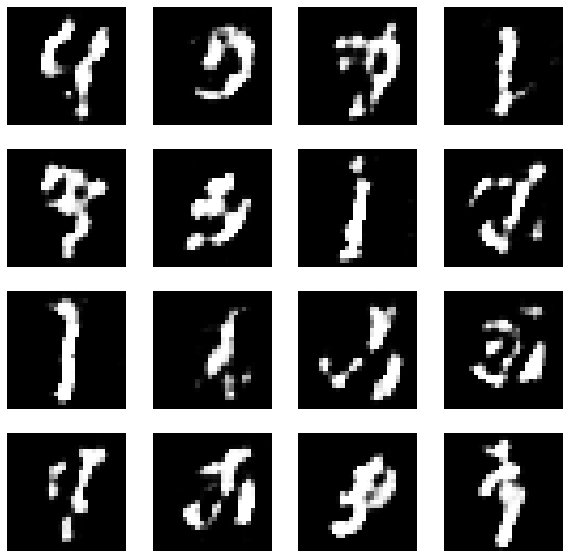

Epoch: 54


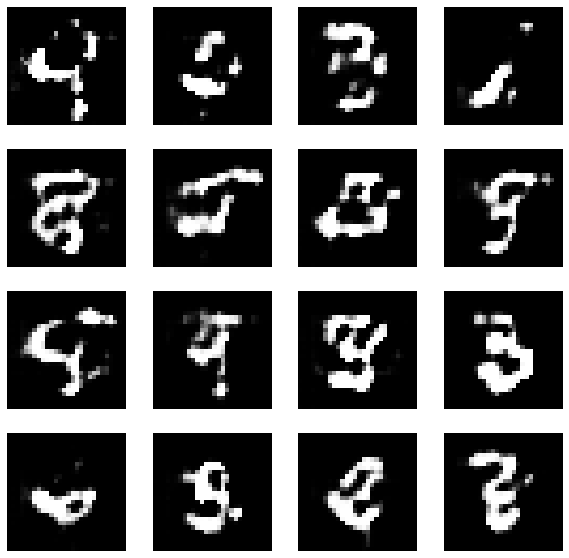

Epoch: 55


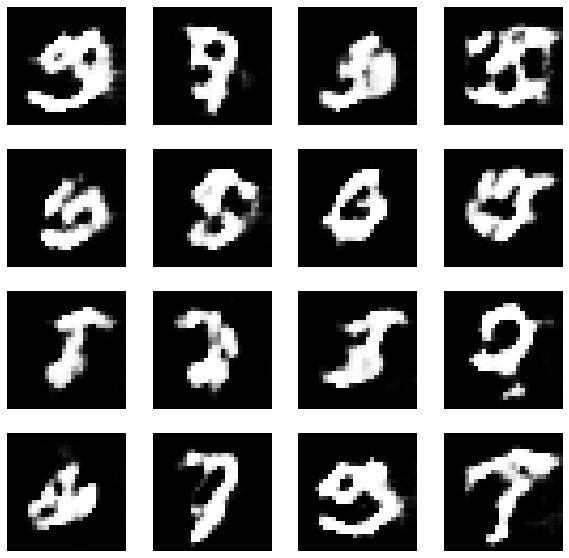

Epoch: 56


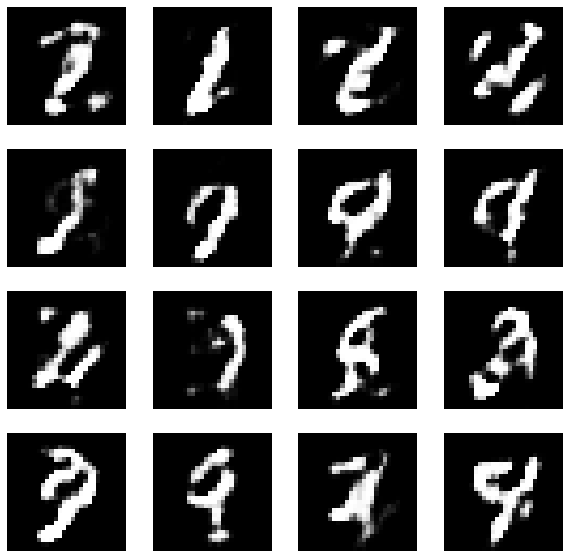

Epoch: 57


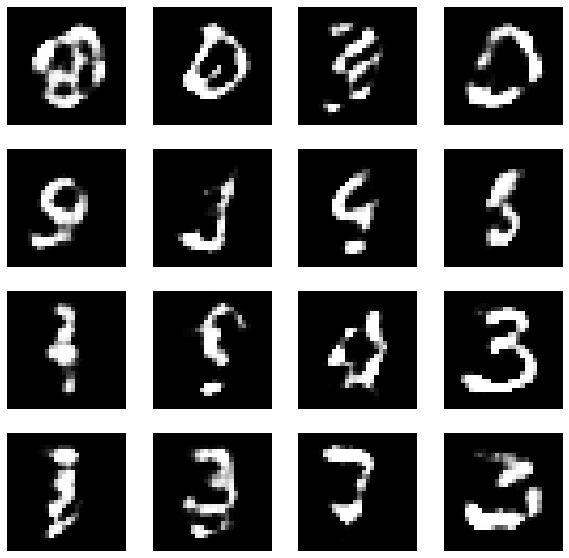

Epoch: 58


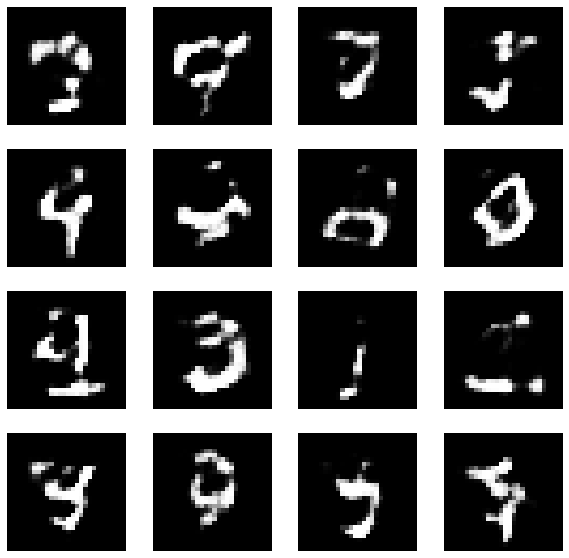

Epoch: 59


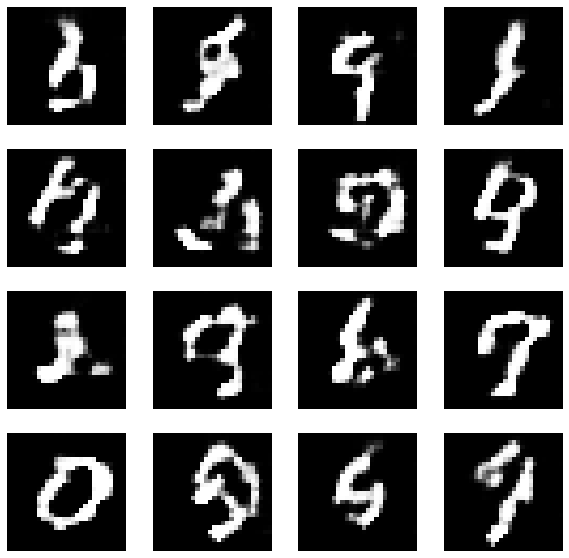

Epoch: 60


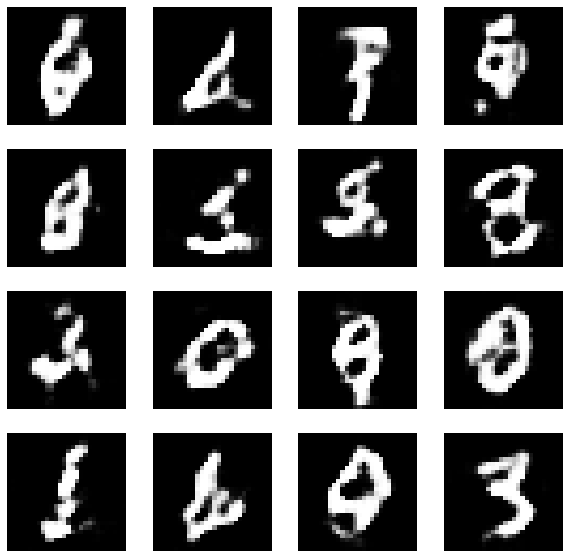

Epoch: 61


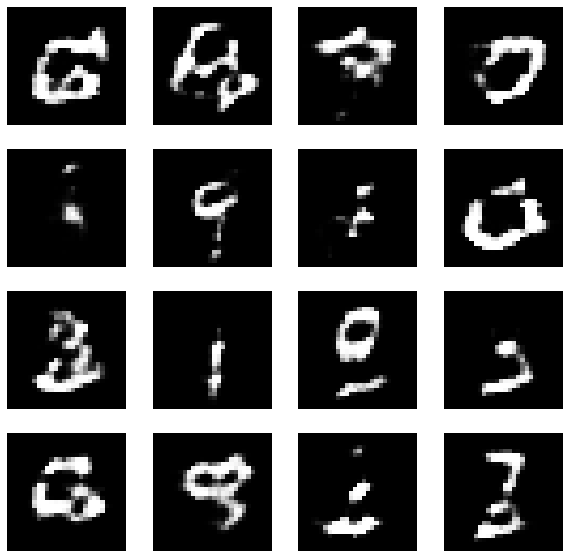

Epoch: 62


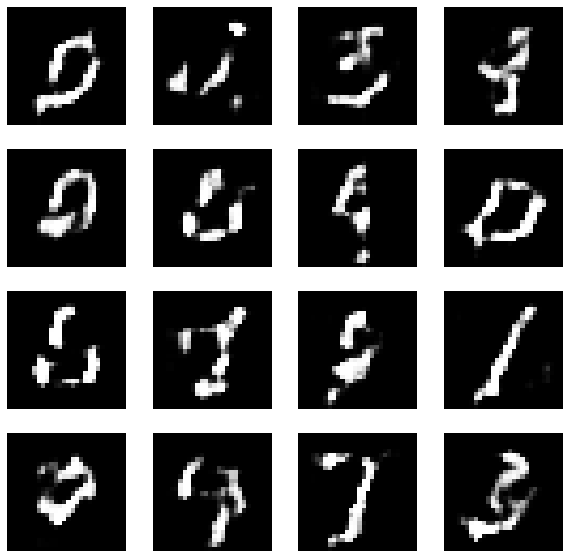

Epoch: 63


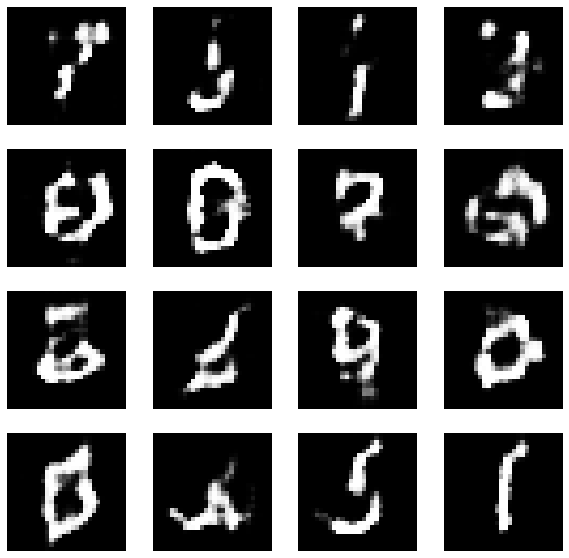

Epoch: 64


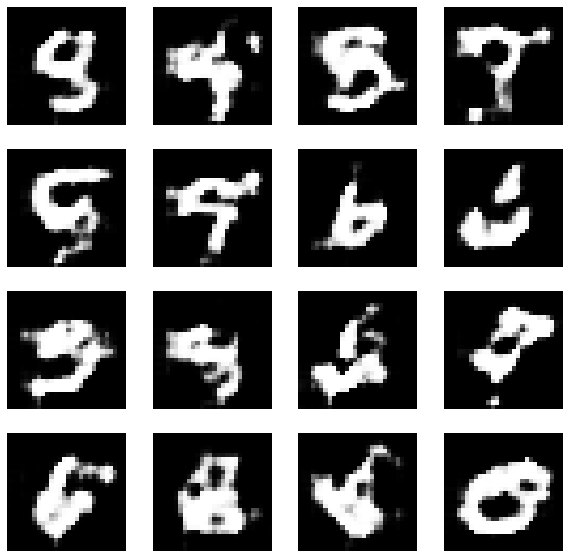

Epoch: 65


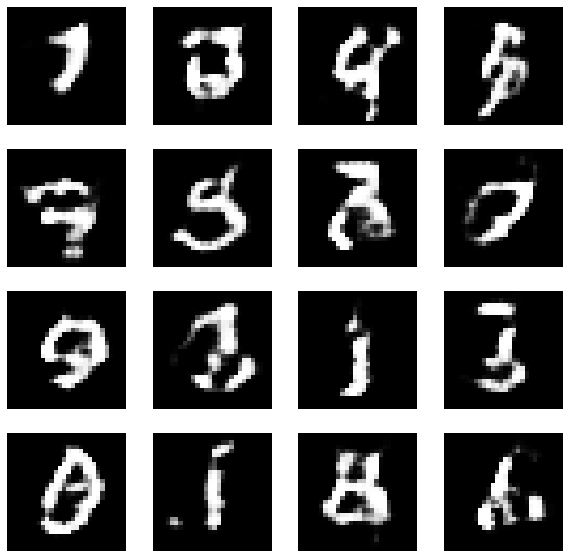

Epoch: 66


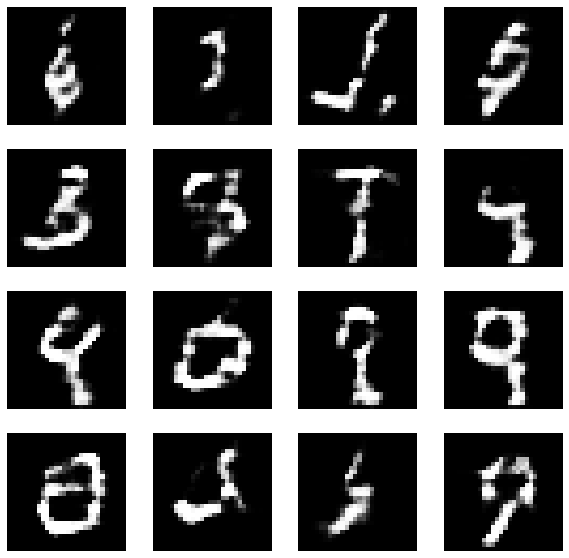

Epoch: 67


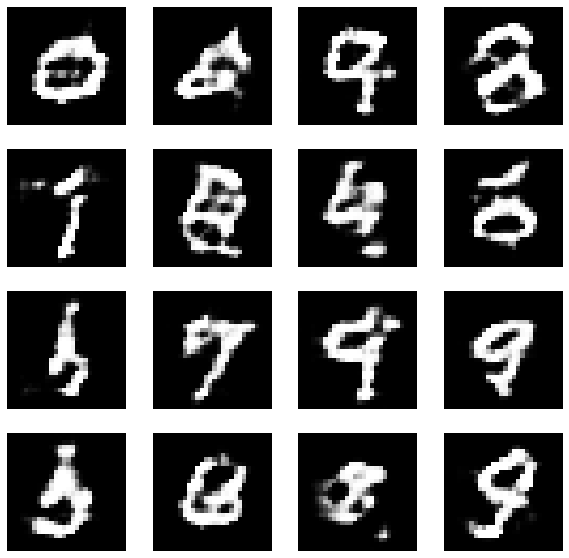

Epoch: 68


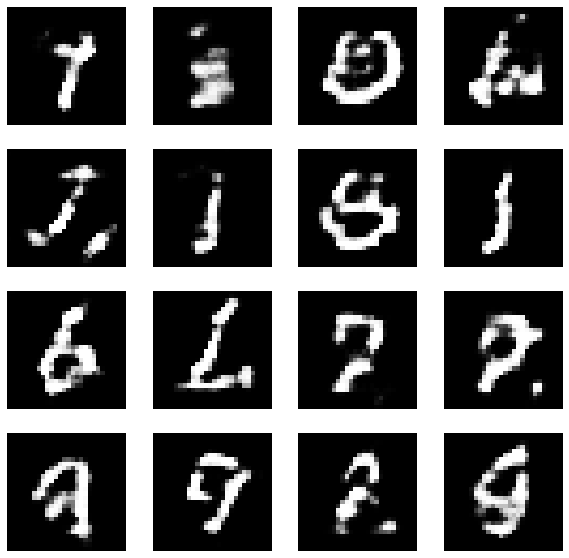

Epoch: 69


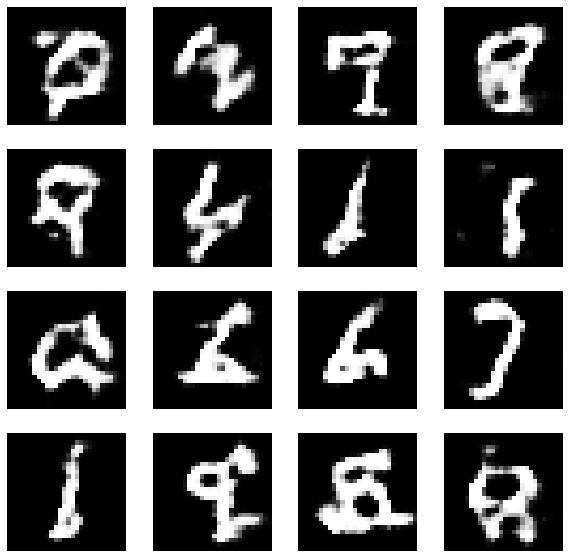

Epoch: 70


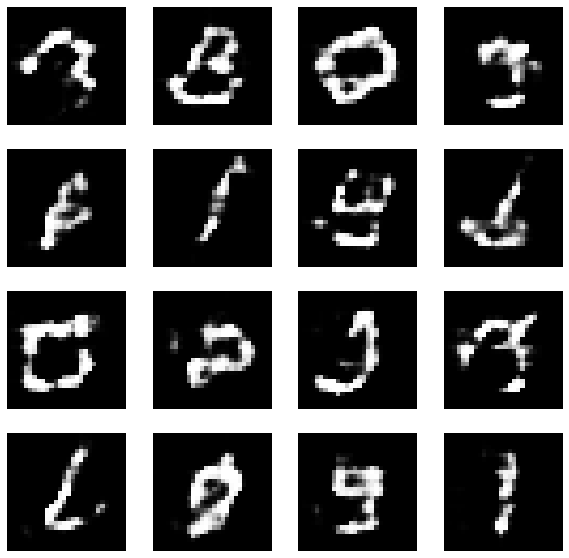

Epoch: 71


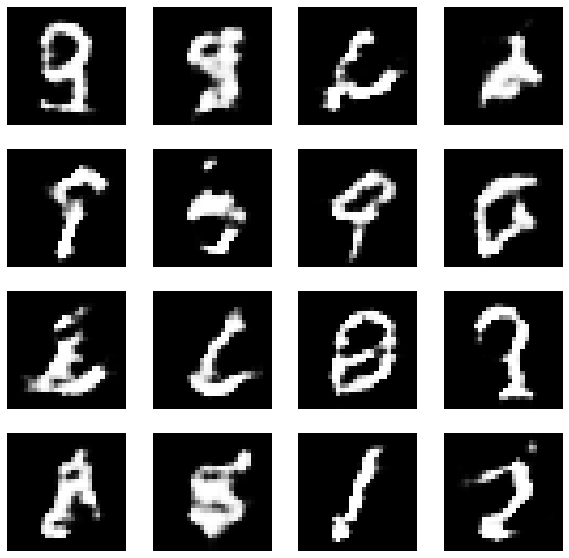

Epoch: 72


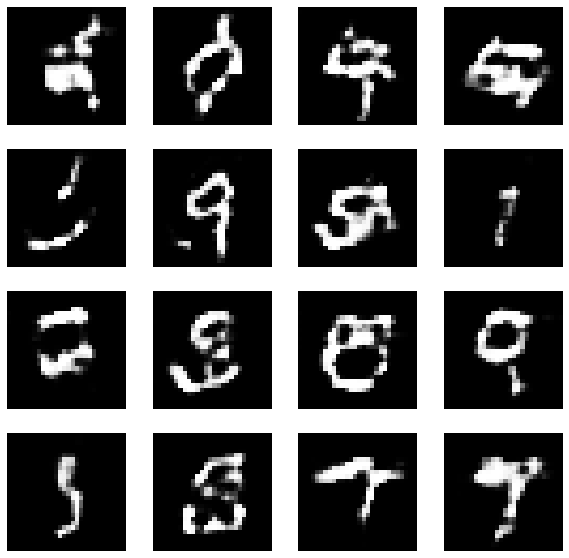

Epoch: 73


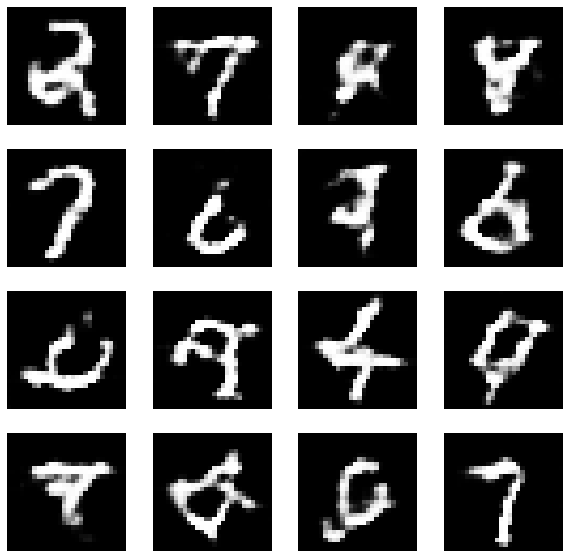

Epoch: 74


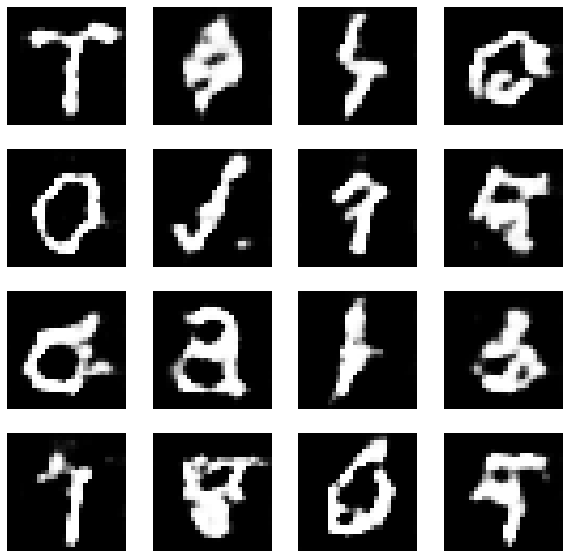

Epoch: 75


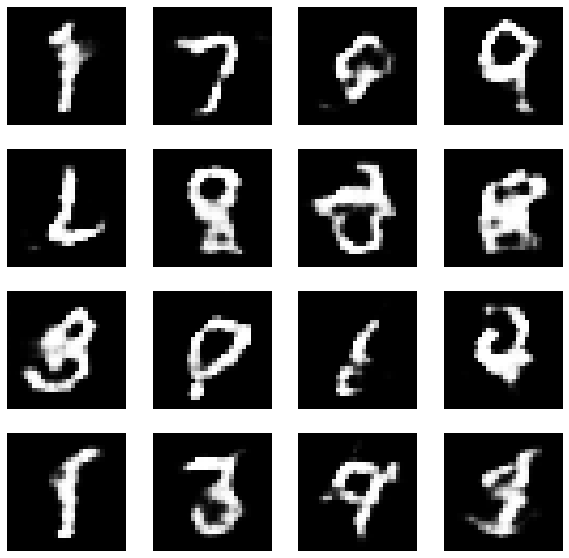

Epoch: 76


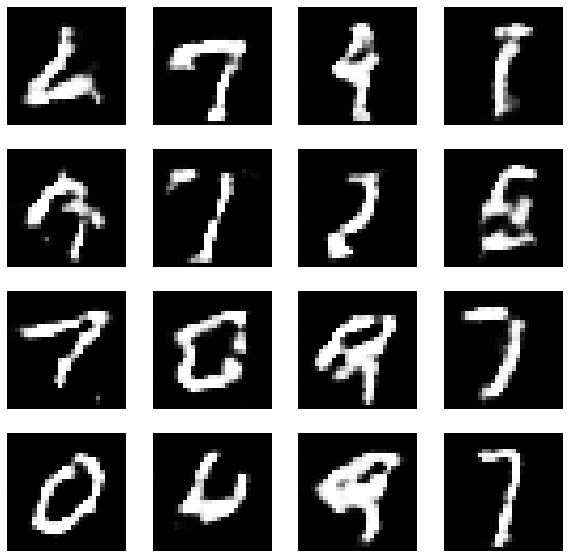

Epoch: 77


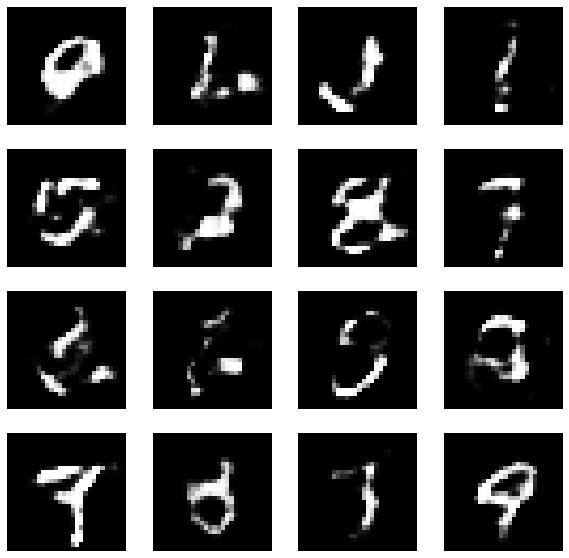

Epoch: 78


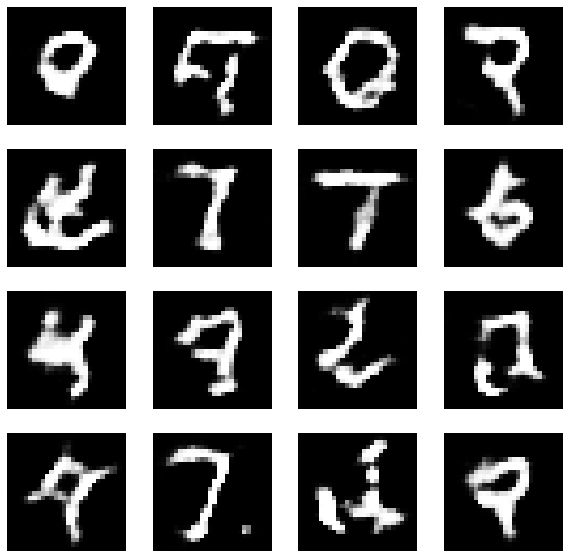

Epoch: 79


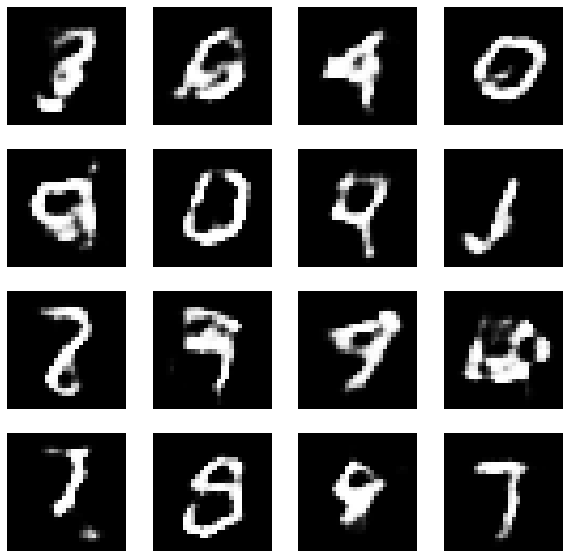

Epoch: 80


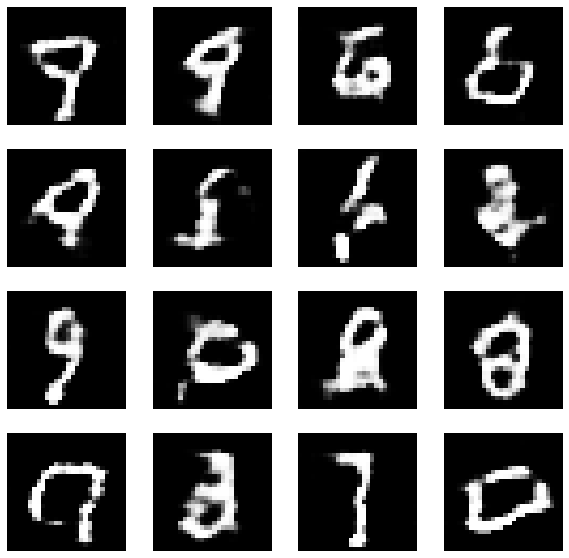

Epoch: 81


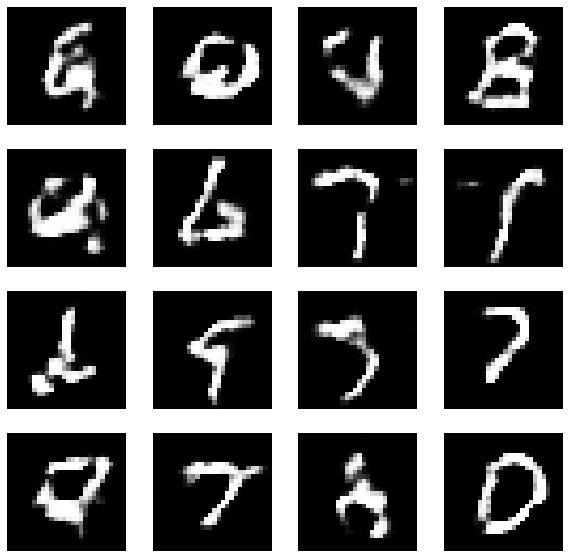

Epoch: 82


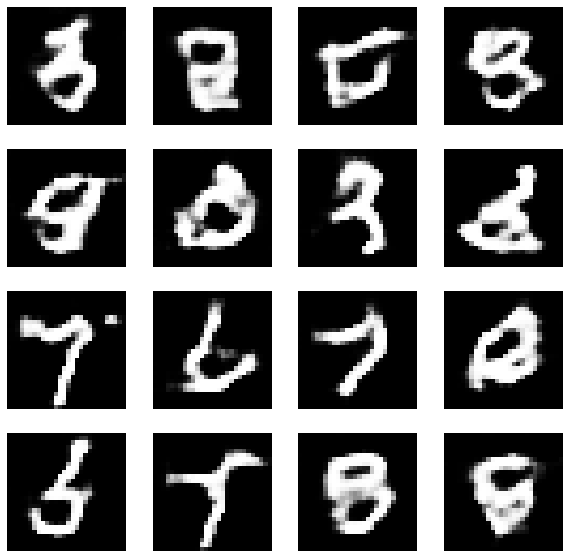

Epoch: 83


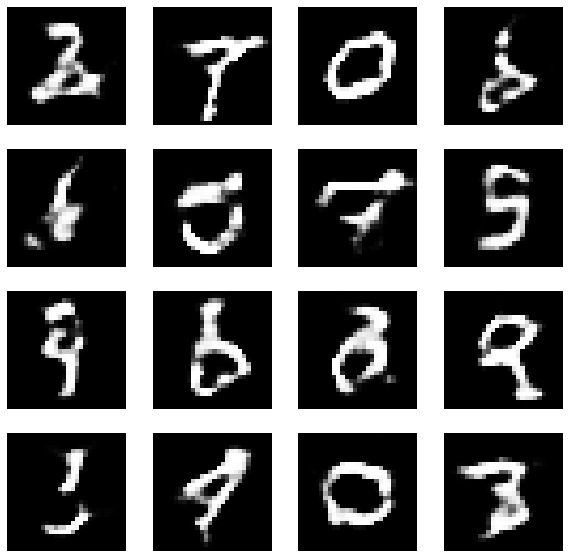

Epoch: 84


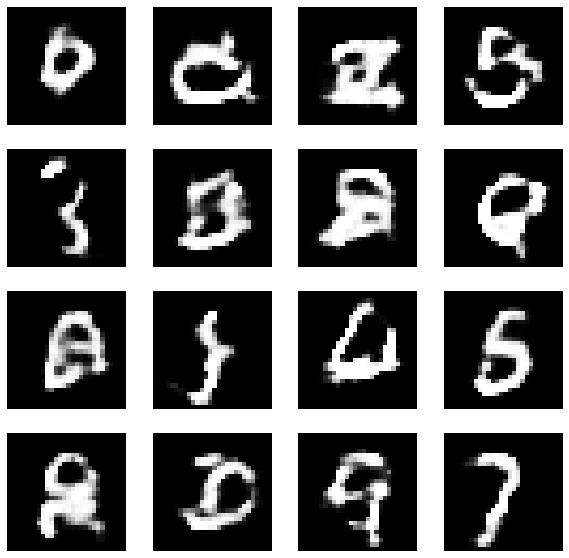

Epoch: 85


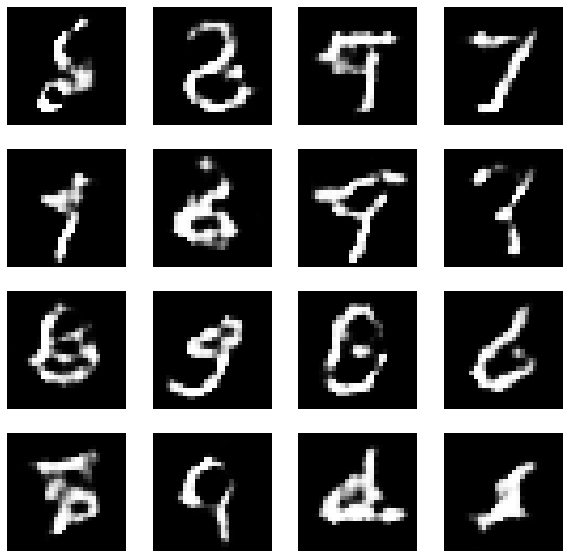

Epoch: 86


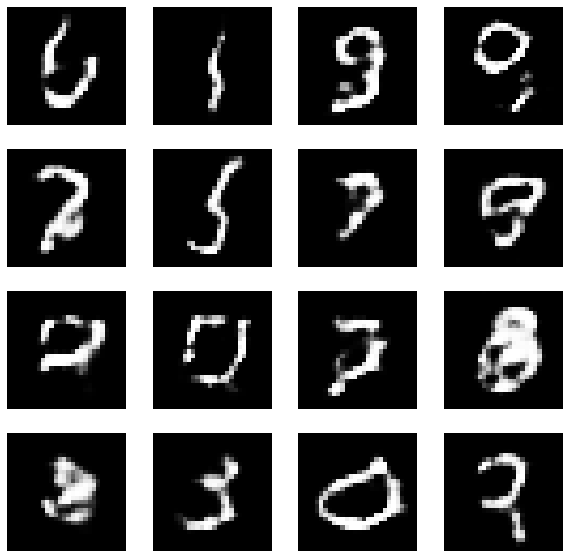

Epoch: 87


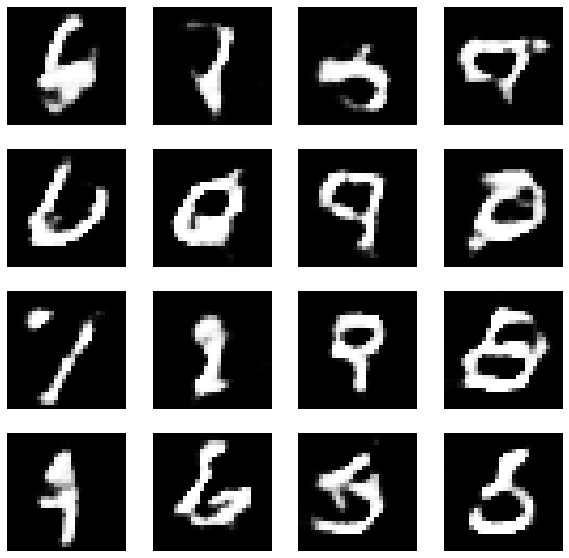

Epoch: 88


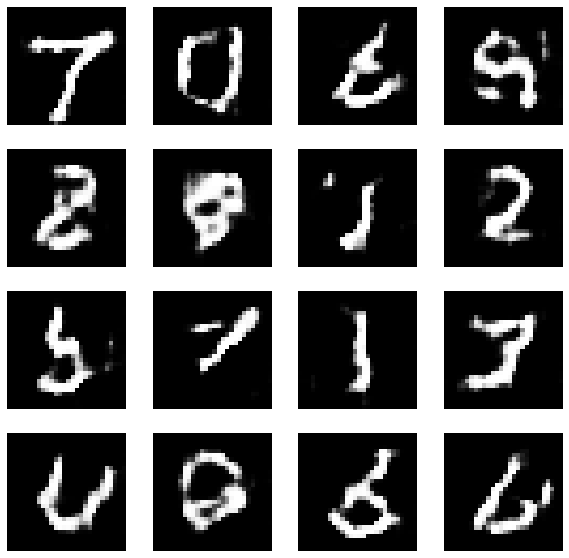

Epoch: 89


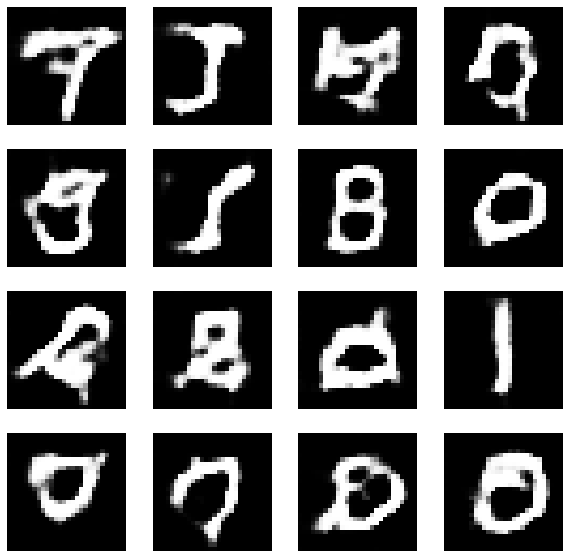

Epoch: 90


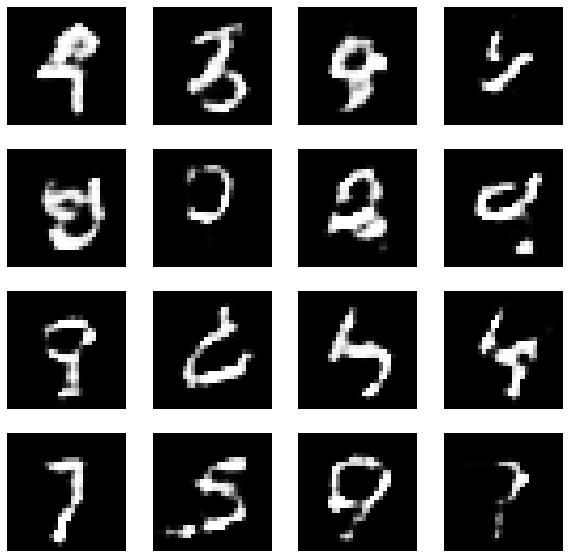

Epoch: 91


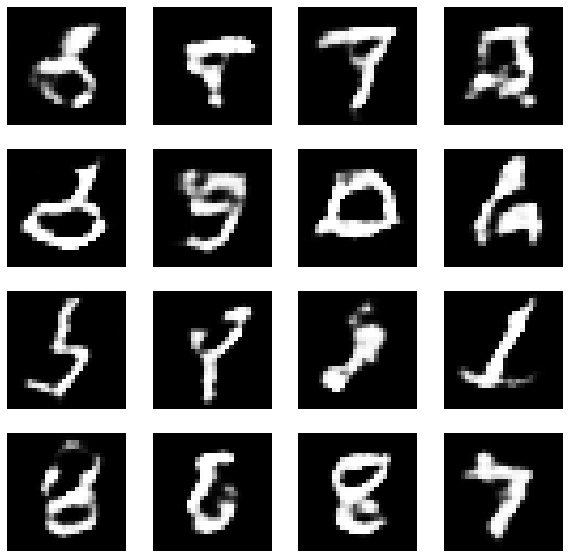

Epoch: 92


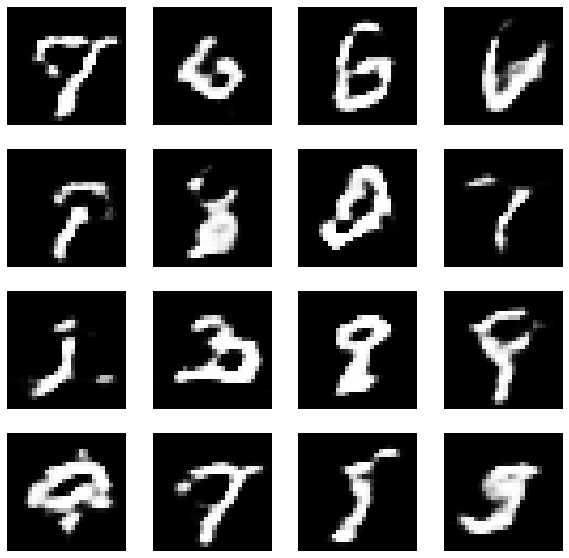

Epoch: 93


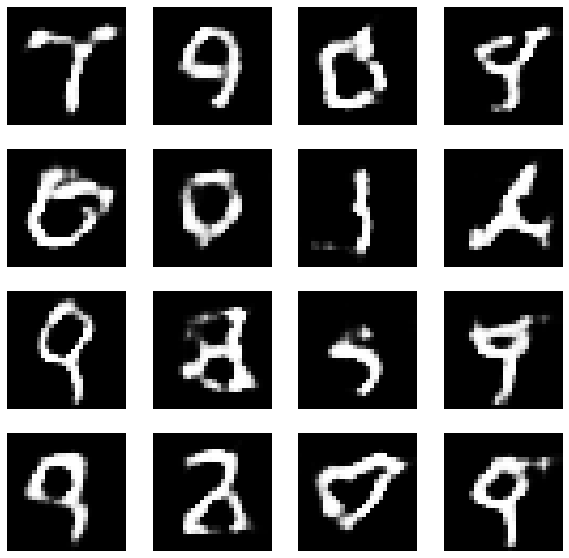

Epoch: 94


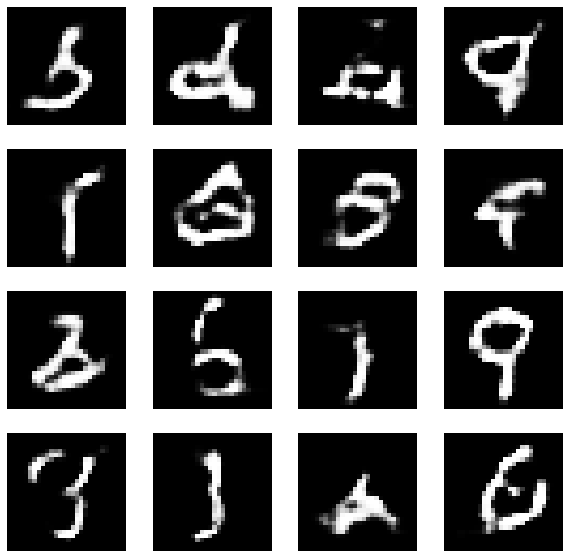

Epoch: 95


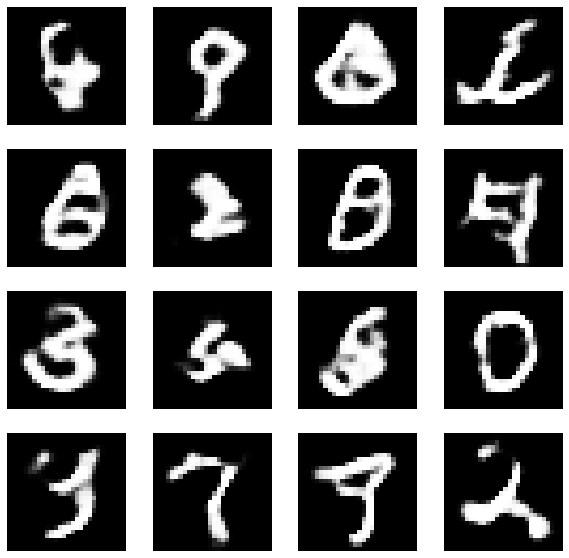

Epoch: 96


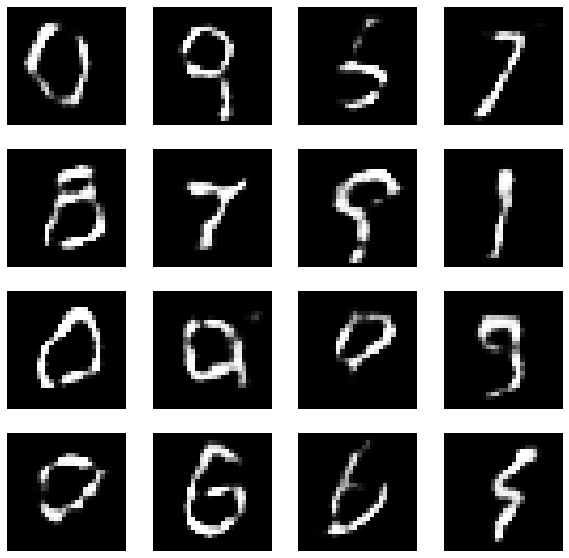

Epoch: 97


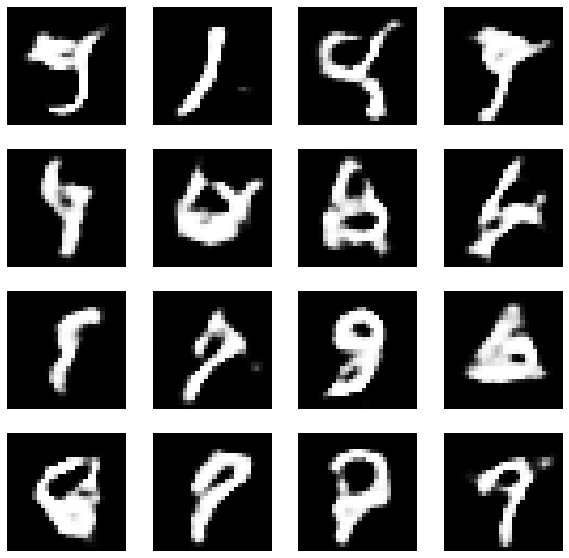

Epoch: 98


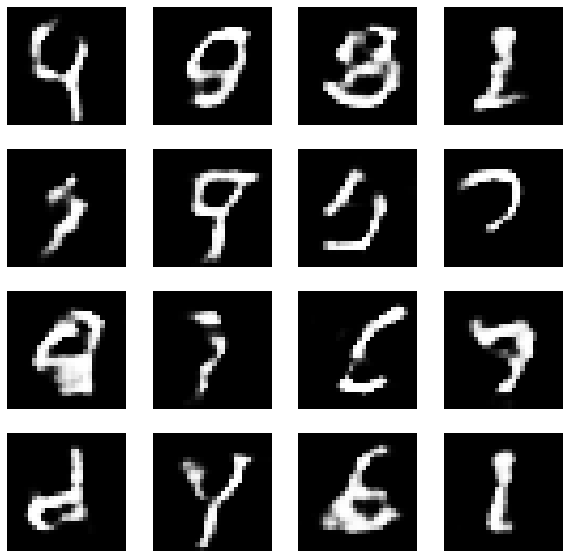

Epoch: 99


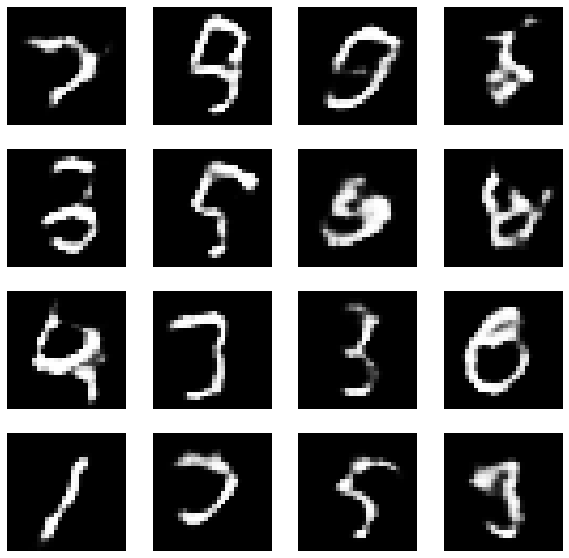

Epoch: 100


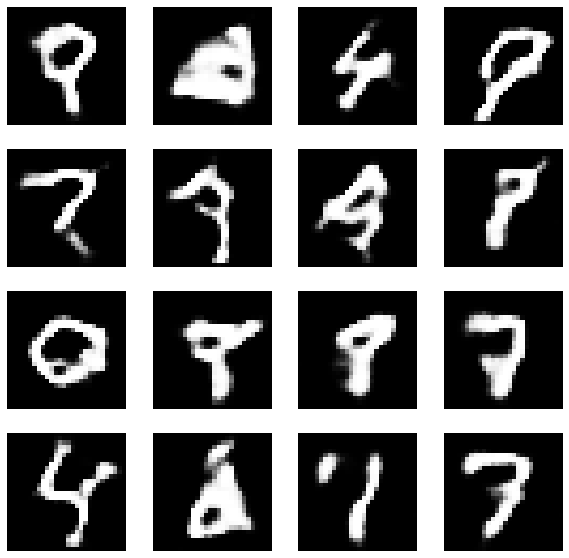

GAN trained with success!


In [ ]:
dcgan.train_gan(dataset=x_train, epochs=100, batch_size=batch_size)